In [1]:
import json
import torch
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from utils import save_checkpoint_single_model, dotdictify
from Transformer_SSL.models import build_model
from dfc_dataset import DFCDataset


DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

data_config = {
    'train_dir': 'data/data_disini', # path to the training directory,  
    'val_dir': 'data/data_disini', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 5, 
    'target': 'dfc_label'
}

train_dataset = DFCDataset(
    data_config['train_dir'],
    mode=data_config['train_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['train_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_train'],
    seed=data_config['seed'],
)

val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed'],
)

/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DFC_map_clean

{0: 'Forest',
 1: 'Shrubland',
 2: 'Grassland',
 3: 'Wetlands',
 4: 'Croplands',
 5: 'Urban/Built-up',
 6: 'Barren',
 7: 'Water',
 255: 'Invalid'}

0.0
Forest


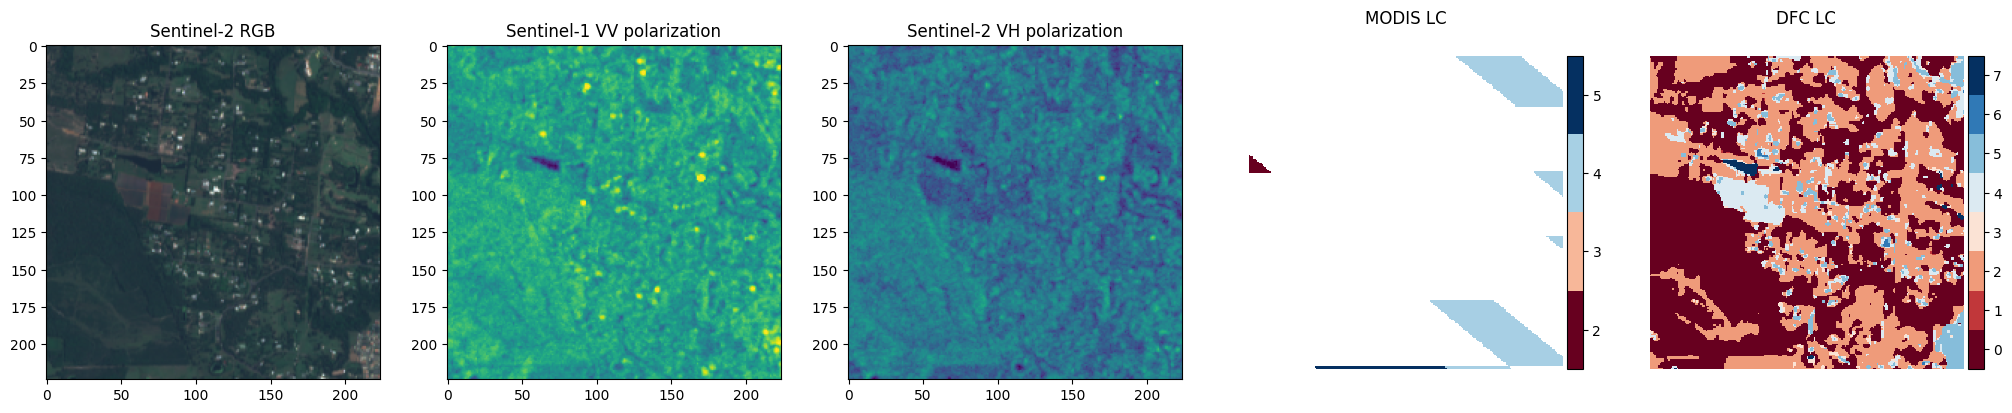

In [3]:
index = 101
print(val_dataset[index]['dfc_label'])
print(DFC_map_clean[val_dataset[index]['dfc_label']])
val_dataset.visualize_observation(index)

In [4]:
len(val_dataset)

5128

In [5]:
len(train_dataset)

986

In [6]:
all_label = [DFC_map_clean[train_dataset[i]['dfc_label']] for i in range(len(train_dataset))]
all_label

['Shrubland',
 'Water',
 'Wetlands',
 'Water',
 'Urban/Built-up',
 'Forest',
 'Wetlands',
 'Water',
 'Forest',
 'Water',
 'Croplands',
 'Forest',
 'Wetlands',
 'Shrubland',
 'Water',
 'Water',
 'Water',
 'Urban/Built-up',
 'Water',
 'Water',
 'Water',
 'Croplands',
 'Water',
 'Croplands',
 'Grassland',
 'Water',
 'Wetlands',
 'Water',
 'Grassland',
 'Water',
 'Water',
 'Water',
 'Water',
 'Croplands',
 'Wetlands',
 'Forest',
 'Croplands',
 'Water',
 'Wetlands',
 'Croplands',
 'Croplands',
 'Croplands',
 'Grassland',
 'Water',
 'Wetlands',
 'Forest',
 'Water',
 'Water',
 'Wetlands',
 'Water',
 'Urban/Built-up',
 'Croplands',
 'Water',
 'Grassland',
 'Barren',
 'Grassland',
 'Grassland',
 'Croplands',
 'Water',
 'Urban/Built-up',
 'Water',
 'Grassland',
 'Croplands',
 'Croplands',
 'Croplands',
 'Forest',
 'Water',
 'Croplands',
 'Water',
 'Wetlands',
 'Wetlands',
 'Wetlands',
 'Water',
 'Croplands',
 'Barren',
 'Barren',
 'Barren',
 'Water',
 'Wetlands',
 'Croplands',
 'Water',
 'Barren

In [8]:
all_label_dict = {}
for l in all_label:
    if l not in all_label_dict:
        all_label_dict[l] = 1
    else:
        all_label_dict[l] += 1
all_label_dict

{'Shrubland': 37,
 'Water': 353,
 'Wetlands': 179,
 'Urban/Built-up': 61,
 'Forest': 76,
 'Croplands': 156,
 'Grassland': 104,
 'Barren': 20}

In [9]:
all_label_val = [DFC_map_clean[val_dataset[i]['dfc_label']] for i in range(len(val_dataset))] 
all_label__val_dict = {}
for l in all_label_val:
    if l not in all_label__val_dict:
        all_label__val_dict[l] = 1
    else:
        all_label__val_dict[l] += 1
all_label__val_dict

{'Water': 1198,
 'Forest': 1508,
 'Croplands': 1204,
 'Urban/Built-up': 541,
 'Grassland': 289,
 'Shrubland': 280,
 'Barren': 79,
 'Wetlands': 29}

In [18]:
categories = all_label_dict.keys()

for x in categories:
    print(f"{x}: {all_label_dict[x]/(all_label_dict[x] + all_label__val_dict[x])}")

Shrubland: 0.1167192429022082
Water: 0.22759509993552546
Wetlands: 0.8605769230769231
Urban/Built-up: 0.10132890365448505
Forest: 0.047979797979797977
Croplands: 0.11470588235294117
Grassland: 0.26463104325699743
Barren: 0.20202020202020202


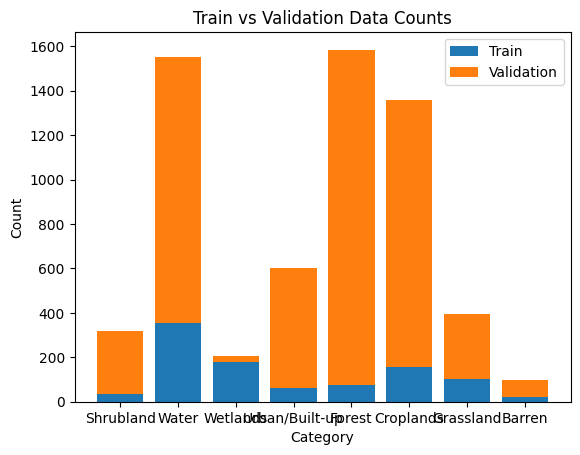

In [13]:
import matplotlib.pyplot as plt

# Align the data
categories = all_label_dict.keys()
train_values = [all_label_dict[category] for category in categories]
val_values = [all_label__val_dict[category] for category in categories]

# Create a bar plot
fig, ax = plt.subplots()

ax.bar(categories, train_values, label='Train')
ax.bar(categories, val_values, bottom=train_values, label='Validation')

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Train vs Validation Data Counts')
plt.legend()

# Show the plot
plt.show()

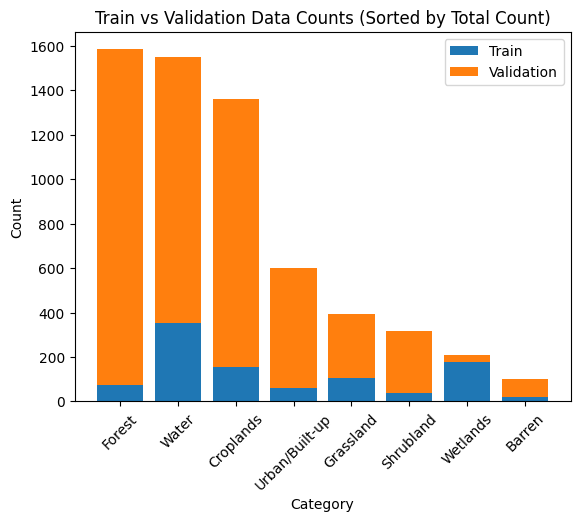

In [15]:
import matplotlib.pyplot as plt

# Given dictionaries

# Calculate total counts and sort categories
total_counts = {category: all_label_dict.get(category, 0) + all_label__val_dict.get(category, 0) for category in set(all_label_dict).union(all_label__val_dict)}
sorted_categories = sorted(total_counts, key=total_counts.get, reverse=True)

# Align data according to sorted categories
train_values = [all_label_dict.get(category, 0) for category in sorted_categories]
val_values = [all_label__val_dict.get(category, 0) for category in sorted_categories]

# Create a bar plot
fig, ax = plt.subplots()

ax.bar(sorted_categories, train_values, label='Train')
ax.bar(sorted_categories, val_values, bottom=train_values, label='Validation')

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Train vs Validation Data Counts (Sorted by Total Count)')
plt.xticks(rotation=45) # Rotate category names for better readability
plt.legend()

# Show the plot
plt.show()

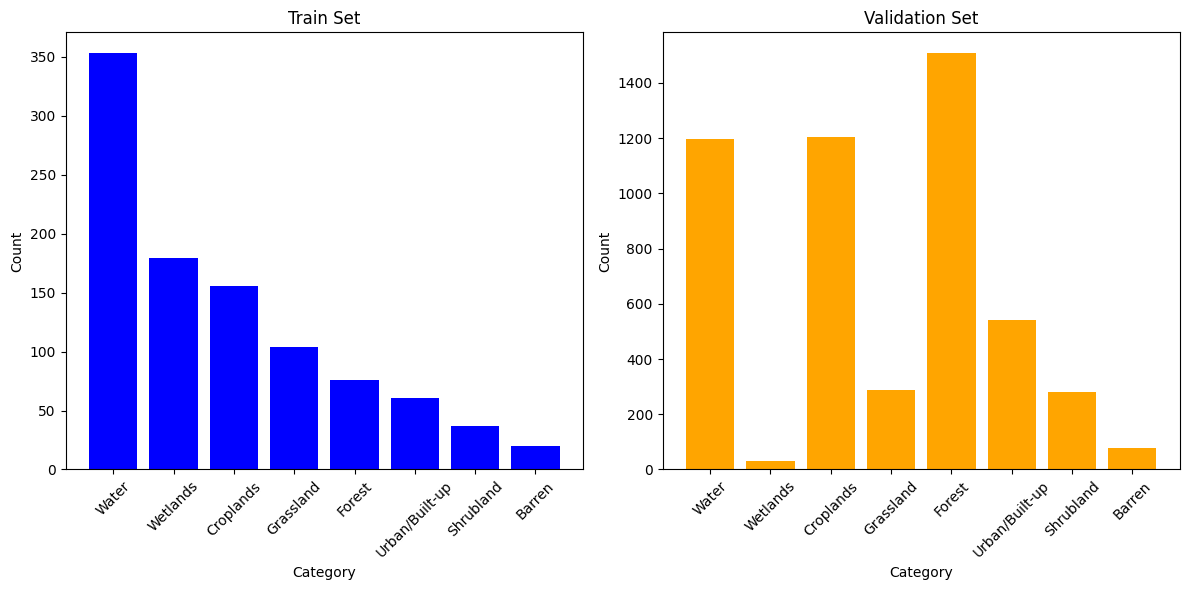

In [16]:
import matplotlib.pyplot as plt


# Sort categories based on train set values
sorted_categories = sorted(all_label_dict, key=all_label_dict.get, reverse=True)

# Align data according to sorted categories
train_values = [all_label_dict[category] for category in sorted_categories]
val_values = [all_label__val_dict.get(category, 0) for category in sorted_categories]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1 row, 2 columns

# Train set plot
axes[0].bar(sorted_categories, train_values, color='blue')
axes[0].set_title('Train Set')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Validation set plot
axes[1].bar(sorted_categories, val_values, color='orange')
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
